In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np


2025-07-28 10:48:15.044056: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753696095.268058  173346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753696095.348214  173346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-28 10:48:15.529723: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE=128
BATCH_SIZE=16
EPOCHS=50
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


I0000 00:00:1753696103.174539  173346 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

135

[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]
[0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 2]


2025-07-28 10:48:26.168158: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


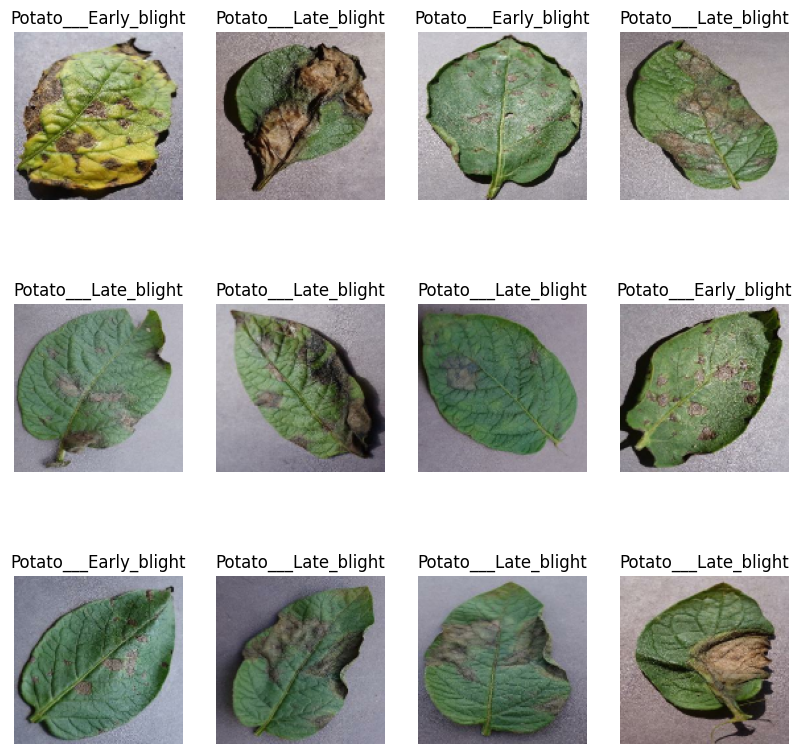

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3 , 4 ,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
        print(label_batch.numpy())

In [7]:
train_size=0.8
len(dataset)*train_size

108.0

In [8]:
train_ds=dataset.take(54)
len(train_ds)

54

In [9]:
test_ds=dataset.skip(54)
len(test_ds)

81

In [10]:
val_size=0.1
len(dataset)*val_size

13.5

In [11]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [12]:
test_ds=test_ds.skip(6)
len(test_ds)

75

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds) 
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

108

In [16]:
len(val_ds)

13

In [17]:
len(test_ds)

14

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resized_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation=data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [21]:
input_shape=(BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model=models.Sequential([
    resized_and_rescale,
    layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape , padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu', input_shape=input_shape,  padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation='relu', input_shape=input_shape,  padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu', input_shape=input_shape,  padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

/home/malek/potatoDiseases/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 128, 128, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 128, 128, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 64, 64, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 64, 64, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 16, 16, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 8, 8, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 4096)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,651 (1.36 MB)

 Trainable params: 355,651 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


I0000 00:00:1753696110.481272  173416 service.cc:148] XLA service 0x7fbb4000f250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753696110.481865  173416 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-07-28 10:48:30.561108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753696110.852564  173416 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-28 10:48:31.604590: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backen

  8/108 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4114 - loss: 1.0405

I0000 00:00:1753696118.698697  173416 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5327 - loss: 0.9063

2025-07-28 10:48:41.557988: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,128,128]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-28 10:48:41.687367: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[16,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,64,64]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivat

108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.5339 - loss: 0.9047 - val_accuracy: 0.8700 - val_loss: 0.3863
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8788 - loss: 0.3565 - val_accuracy: 0.8050 - val_loss: 0.5376
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8750 - loss: 0.3085 - val_accuracy: 0.9200 - val_loss: 0.2135
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9127 - loss: 0.2326 - val_accuracy: 0.9350 - val_loss: 0.1851
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9450 - loss: 0.1579 - val_accuracy: 0.9600 - val_loss: 0.1107
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9597 - loss: 0.1262 - val_accuracy: 0.9300 - val_loss: 0.1837
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9401 - loss: 0.1526 - val_accuracy: 0.9750 - val_loss: 0.0820
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9516 - loss: 0.1101 - val_accuracy: 0.98

In [25]:
scores=model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9882 - loss: 0.0337    


In [26]:
scores

[0.05559973791241646, 0.9821428656578064]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 108}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

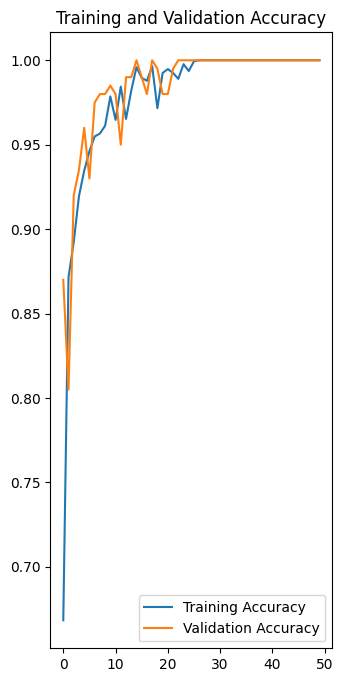

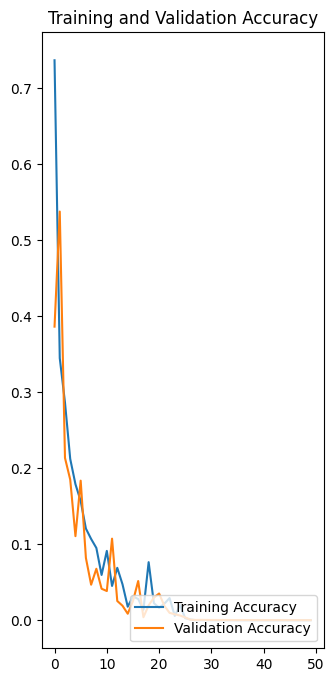

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
predicted: Potato___healthy


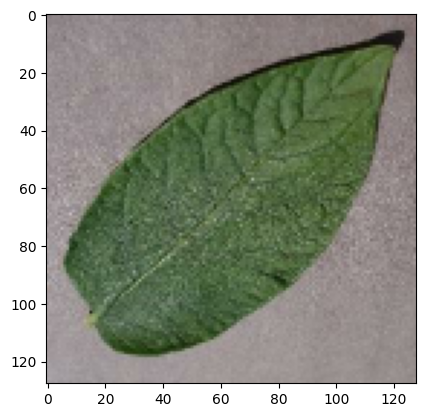

In [43]:
for image_batch, label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])

    batch_presiction=model.predict(image_batch)
    print("predicted:",class_names[np.argmax(batch_presiction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

2025-07-28 10:50:17.708139: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,64,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,32]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-07-28 10:50:17.803248: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[1,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,16,16]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


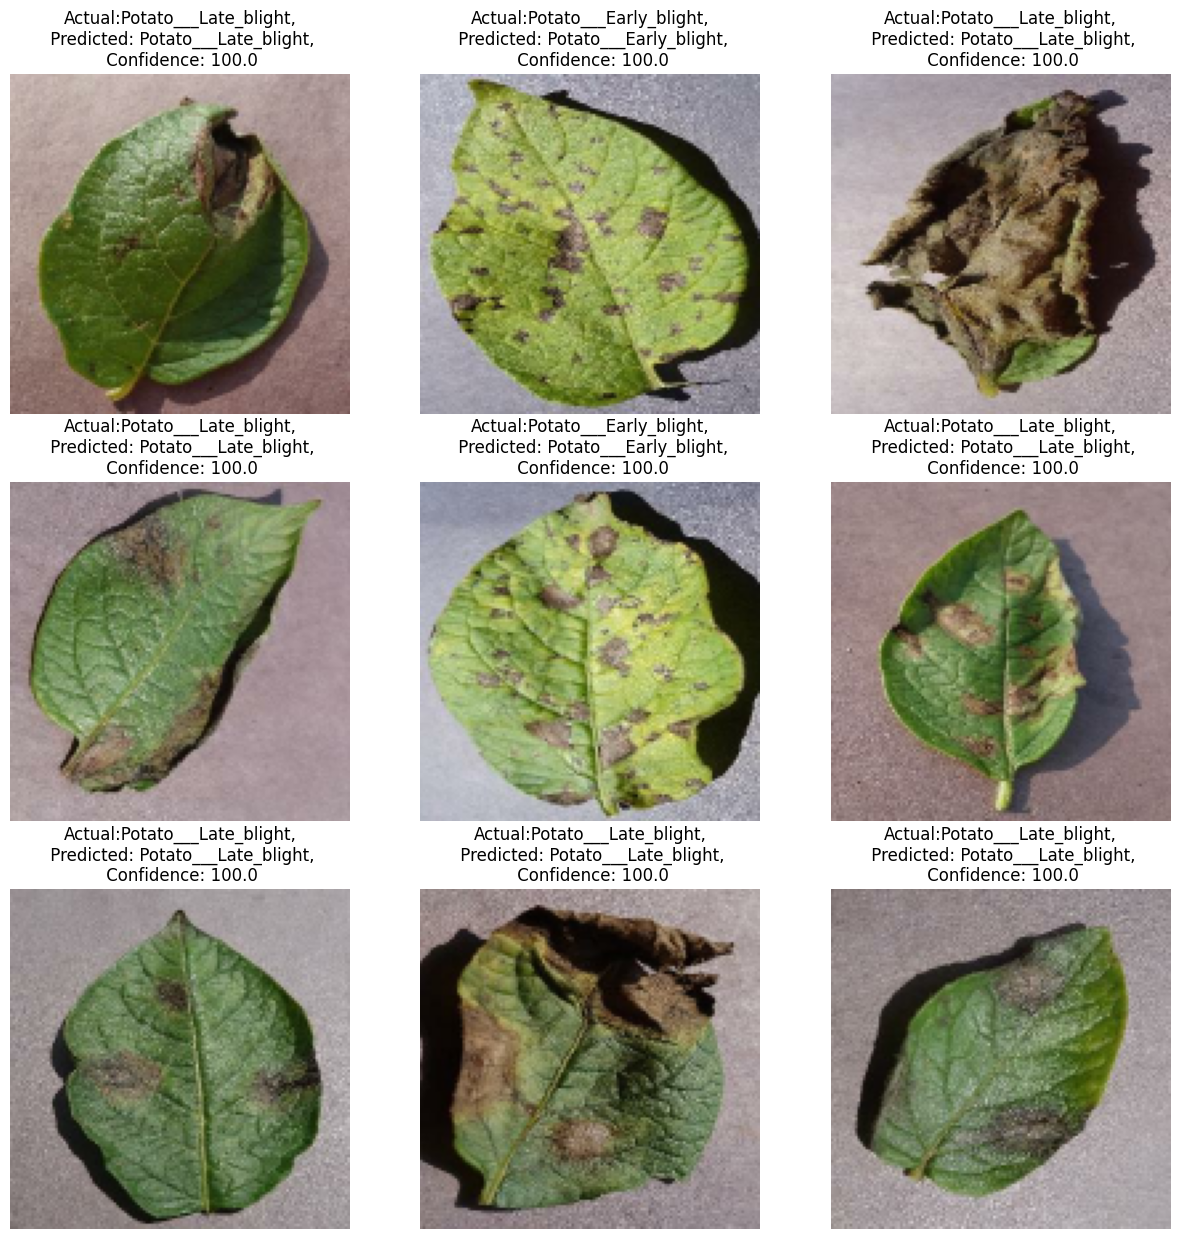

In [34]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence=predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off") 

In [35]:
import os
os.makedirs("models", exist_ok=True)


In [46]:
import os

os.makedirs("models", exist_ok=True)
existing_versions = [int(i) for i in os.listdir("models") if i.isdigit()]
model_version = max(existing_versions, default=0) + 1

model.export(f"models/{model_version}")


INFO:tensorflow:Assets written to: models/3/assets


INFO:tensorflow:Assets written to: models/3/assets


Saved artifact at 'models/3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140445740579920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445740580496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445740576464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445740578768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700932624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700932048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700932816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700932240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700934352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445700931664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445740577616: Tenso